In [ ]:
!pip install scikit-learn
!pip install seaborn
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

In [ ]:
'''

https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

One project used linear regressions on price prediction achieved an R^2 of 0.62

Another project used linear regression with an R^2 of 0.65 and random forest with an R^2 of 0.61

'''

In [ ]:
df = pd.read_csv('Housing.csv')

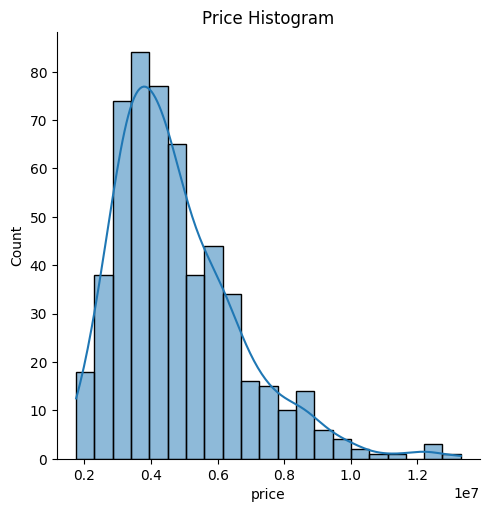

In [ ]:
sns.displot(data=df['price'], kde=True).set(title='Price Histogram')

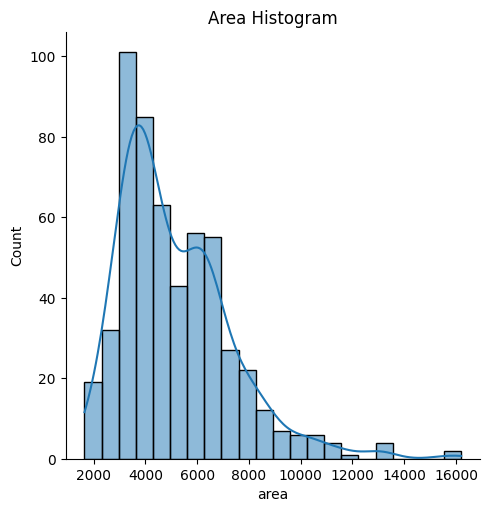

In [ ]:
sns.displot(data=df['area'], kde=True).set(title='Area Histogram')

<Axes: title={'center': 'Furnished Status Pie Chart'}>

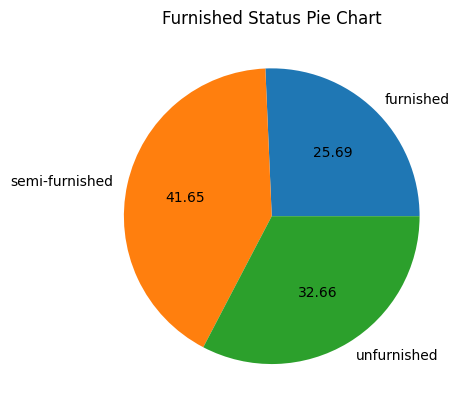

In [ ]:
df.groupby('furnishingstatus').size().plot(kind='pie', autopct='%.2f', title='Furnished Status Pie Chart')

In [ ]:
'''

Target variable, price, seems right skewed which makes sense as there can be
incredibly expensive homes but no $2 homes.
Area also seems to be right skewed for the same reasons.

Balances of the furnished feature seems to be fairly even.

'''

In [ ]:
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']])

In [ ]:
transform_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
col_trans = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), transform_columns)
], remainder='passthrough')
features = col_trans.fit_transform(df.loc[:, df.columns != 'price'])
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.2)

In [ ]:
'''

Data is split into 80% train, 20% test, shuffled
Categorical features are encoded in a one hot fashion

'''

In [ ]:
# baseline, always predict mean of y train
y_naive = [np.mean(y_train)] * len(y_test)
baseline_score = r2_score(y_test, y_naive)
print(baseline_score)

-0.014388601906094589


In [ ]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
linreg_score = linreg.score(x_test, y_test)
print(linreg_score)

0.6537727446519617


In [ ]:
lasso = LassoCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 3, 5, 8, 10])
lasso.fit(x_train, y_train)
lasso_score = lasso.score(x_test, y_test)
print(lasso_score)

0.6537727445189817


In [ ]:
ridge = RidgeCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 3, 5, 8, 10])
ridge.fit(x_train, y_train)
ridge_score = ridge.score(x_test, y_test)
print(ridge_score)

0.6575524668431729


In [ ]:
enet = ElasticNetCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 3, 5, 8, 10])
enet.fit(x_train, y_train)
enet_score = enet.score(x_test, y_test)
print(enet_score)

0.6583166211112913


In [ ]:
huber = HuberRegressor()
huber.fit(x_train, y_train)
huber_score = huber.score(x_test, y_test)
print(huber_score)

0.005649046047576101


In [ ]:
mlp = MLPRegressor(random_state=0, max_iter=500)
mlp.fit(x_train, y_train)
mlp_score = mlp.score(x_test, y_test)
print(mlp_score)

-2.9875327468508344


In [ ]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(x_train, y_train)
svr_rbf_score = svr_rbf.score(x_test, y_test)
print(svr_rbf_score)

-0.1290974878252127


In [ ]:
svr_poly = SVR(kernel='poly')
svr_poly.fit(x_train, y_train)
svr_poly_score = svr_poly.score(x_test, y_test)
print(svr_poly_score)

-0.12877376527588913


In [ ]:
svr_lin = SVR(kernel='linear')
svr_lin.fit(x_train, y_train)
svr_lin_score = svr_lin.score(x_test, y_test)
print(svr_lin_score)

0.2493483667126748


[Text(0.5, 0, 'Models'),
 Text(0, 0.5, 'R^2 Scores'),
 Text(0.5, 1.0, 'Model R^2 Comparisons')]

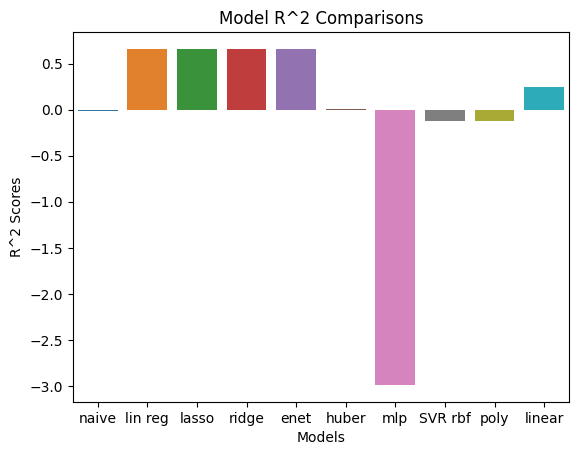

In [ ]:
scores = pd.DataFrame.from_dict({'naive': [baseline_score],
                                 'lin reg': [linreg_score],
                                 'lasso': [lasso_score],
                                 'ridge': [ridge_score],
                                 'enet': [enet_score],
                                 'huber': [huber_score],
                                 'mlp': [mlp_score],
                                 'SVR rbf': [svr_rbf_score],
                                 'poly': [svr_poly_score],
                                 'linear': [svr_lin_score]})
sns.barplot(data=scores).set(xlabel='Models', ylabel='R^2 Scores', title='Model R^2 Comparisons')

In [ ]:
# global feature importance
feature_names = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
r = permutation_importance(linreg, x_test, y_test,
                           n_repeats=10,
                           random_state=0)

most_important = set()
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    idx = i//2 if i <= 14 else i - 8
    if i == 14:
      idx -= 1
    if idx not in most_important:
      print(f"{feature_names[idx]:<20}"
      f"{r.importances_mean[i]:.5f}"
      f" +/- {r.importances_std[i]:.5f}")
      most_important.add(idx)


area                0.15996 +/- 0.03125
bathrooms           0.15258 +/- 0.02243
stories             0.07344 +/- 0.02531
airconditioning     0.03008 +/- 0.00878
basement            0.00775 +/- 0.00235
guestroom           0.00698 +/- 0.00238


In [ ]:
col_names = ['mainroad', 'mainroad', 'guestroom', 'guestroom', 'basement', 'basement', 'hotwaterheating', 'hotwaterheating', 'airconditioning', 'airconditioning', 'prefarea', 'prefarea', 'furnishingstatus', 'furnishingstatus', 'furnishingstatus', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

x_test_df = pd.DataFrame(x_test, columns=col_names)

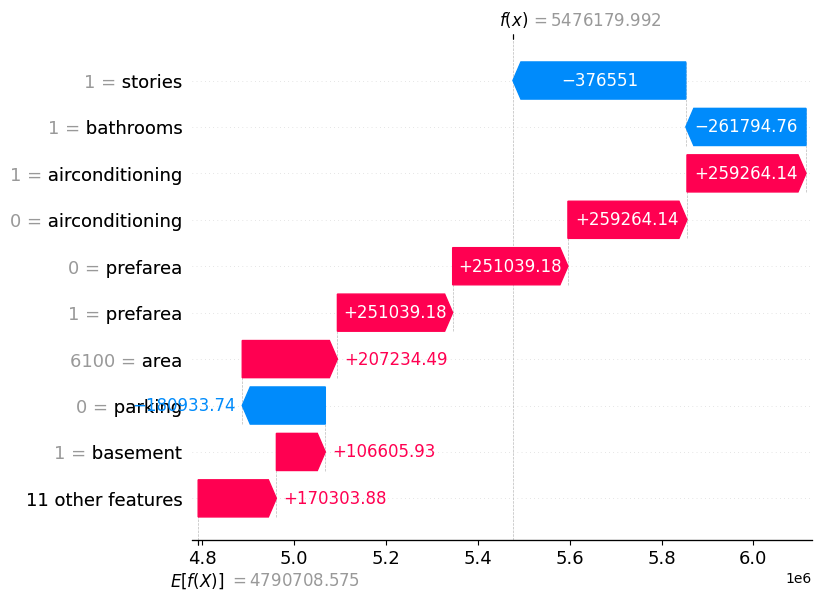

In [ ]:
# local shap
shap.initjs()
x100 = shap.utils.sample(x_test_df, 100)
explainer = shap.Explainer(linreg.predict, x100)
shap_values = explainer(x_test_df)
point_idx = 0
shap.plots.waterfall(shap_values[point_idx])

In [ ]:
'''
Seems like most important features are area, bathrooms, stories, and AC.

Least important features seems to be mainroad, hot water heating, and furnished status.

Makes sense logically going by own experience looking for housing.

In terms of modeling, seems to be a linear relationship as linear models vastly
outperform non linear models.

Could have more aggressively selected for features for simpler and more interpretable models

'''